In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
import keras
from tensorflow import keras
from tensorflow.keras import layers


2023-12-04 20:11:22.591102: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-04 20:11:22.771251: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-04 20:11:22.771350: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-04 20:11:22.808565: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-04 20:11:22.880229: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-04 20:11:22.881263: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
fname = os.path.join("data","jena_climate_2009_2016.csv")
with open(fname) as f:
    data = f.read()
lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [3]:
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

## Prepare the data

In [4]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


In [5]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [6]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples
)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples
)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples
)

2023-12-04 20:11:26.813416: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [7]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


## Base line 

In [8]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen


print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


## Feedforward Neural Network
#### Alterações:
- **Número de neurônios:** Alterado de 16 para 4 neurôneos na primeira camada densa
- **Função de ativação:** Alterada de ReLU para Tanh
- **Otimizador:** Alterado de "rmsprop" para Adam
- **Número de épocas:** Alterado de 10 para 50
- **Batch Normalization:** Adicionamos Batch Normalization
- **Early Stopping:** Adicionamos Early Stopping monitorando a loss da validação e com paciência 10


In [15]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.BatchNormalization()(x)
x = layers.Dense(4, activation="tanh")(x)
x = layers.BatchNormalization()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [13]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 flatten_1 (Flatten)         (None, 1680)              0         
                                                                 
 dense_2 (Dense)             (None, 4)                 6724      
                                                                 
 dense_3 (Dense)             (None, 1)                 5         
                                                                 
Total params: 6729 (26.29 KB)
Trainable params: 6729 (26.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
model.compile(optimizer="adam", loss="mse", metrics=["mae"])
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10),

history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    callbacks=[callback]
)

print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/50


819/819 [==============================] - 13s 15ms/step - loss: 70.5400 - mae: 7.0321 - val_loss: 23.9977 - val_mae: 4.1293
Epoch 2/50
819/819 [==============================] - 14s 17ms/step - loss: 13.1628 - mae: 2.8923 - val_loss: 10.7275 - val_mae: 2.5762
Epoch 3/50
819/819 [==============================] - 14s 17ms/step - loss: 9.6985 - mae: 2.4502 - val_loss: 10.3928 - val_mae: 2.5048
Epoch 4/50
819/819 [==============================] - 14s 17ms/step - loss: 9.6511 - mae: 2.4460 - val_loss: 10.3129 - val_mae: 2.5208
Epoch 5/50
819/819 [==============================] - 14s 17ms/step - loss: 9.5833 - mae: 2.4358 - val_loss: 10.3511 - val_mae: 2.5309
Epoch 6/50
819/819 [==============================] - 14s 17ms/step - loss: 9.5213 - mae: 2.4306 - val_loss: 15.1751 - val_mae: 3.0153
Epoch 7/50
819/819 [==============================] - 14s 17ms/step - loss: 9.4956 - mae: 2.4278 - val_loss: 10.3703 - val_mae: 2.5149
Epoch 8/50
819/819 [==============================] - 15s 18ms/s

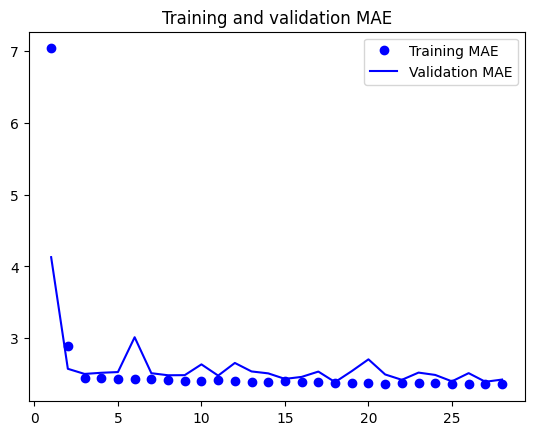

In [17]:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

## 1D convolution neural network
#### Alterações
- **Número de filtros:** Alterado de 8 para 4 filtros de cada camada convolucional
- **Função de ativação:** Alterada de ReLU para Leaky ReLU em cada camada convolucional
- **Otimizador:** Alterado de "rmsprop" para Adam
- **Número de épocas:** Alterado de 10 para 100
- **Batch Normalization:** Adicionamos Batch Normalization
- **Regularização:** Adicionamos regularização L2 em cada camada convolucional
- **Dropout:** Adicionamos Dropout de 20% nas duas primeiras camadas convolucionais
- **Early Stopping:** Adicionamos Early Stopping monitorando a loss da validação e com paciência 10


In [16]:
from keras import layers, regularizers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))

x = layers.Conv1D(4, 24, activation="leaky_relu", 
                  kernel_regularizer=regularizers.l2(0.001))(inputs)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Dropout(0.2)(x) 

x = layers.Conv1D(4, 12, activation="leaky_relu", 
                  kernel_regularizer=regularizers.l2(0.001))(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Dropout(0.2)(x) 

x = layers.Conv1D(4, 6, activation="leaky_relu", 
                  kernel_regularizer=regularizers.l2(0.001))(x)
x = layers.BatchNormalization()(x)
x = layers.GlobalAveragePooling1D()(x)

outputs = layers.Dense(1, kernel_regularizer=regularizers.l2(0.001))(x) 
model = keras.Model(inputs, outputs)

In [17]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 conv1d_9 (Conv1D)           (None, 97, 4)             1348      
                                                                 
 batch_normalization_9 (Bat  (None, 97, 4)             16        
 chNormalization)                                                
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 48, 4)             0         
 g1D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 48, 4)             0         
                                                                 
 conv1d_10 (Conv1D)          (None, 37, 4)             196 

In [13]:
model.compile(optimizer="adam", loss="mse", metrics=["mae"])
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(
    train_dataset,
    epochs=100, 
    validation_data=val_dataset,
    callbacks=[callback]
)

print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")


Epoch 1/100
819/819 [==============================] - 25s 29ms/step - loss: 74.1679 - mae: 7.0189 - val_loss: 36.1718 - val_mae: 4.8308
Epoch 2/100
819/819 [==============================] - 26s 31ms/step - loss: 21.2536 - mae: 3.5991 - val_loss: 15.2774 - val_mae: 3.0712
Epoch 3/100
819/819 [==============================] - 26s 31ms/step - loss: 16.9667 - mae: 3.2617 - val_loss: 14.2674 - val_mae: 2.9372
Epoch 4/100
819/819 [==============================] - 26s 32ms/step - loss: 16.0303 - mae: 3.1665 - val_loss: 13.5214 - val_mae: 2.8679
Epoch 5/100
819/819 [==============================] - 26s 32ms/step - loss: 15.2993 - mae: 3.0923 - val_loss: 13.2972 - val_mae: 2.8272
Epoch 6/100
819/819 [==============================] - 26s 32ms/step - loss: 14.7189 - mae: 3.0295 - val_loss: 12.4930 - val_mae: 2.7657
Epoch 7/100
819/819 [==============================] - 26s 32ms/step - loss: 14.2929 - mae: 2.9833 - val_loss: 12.1561 - val_mae: 2.7159
Epoch 8/100
819/819 [====================

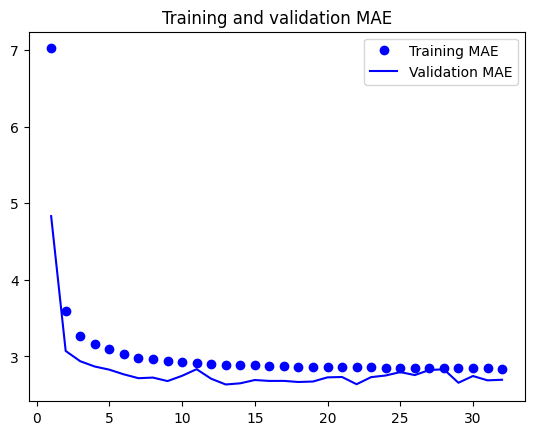

In [15]:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()